## **Deep Embedded Clustering (DEC)**

In [1]:
!pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for umap-learn from https://files.pythonhosted.org/packages/43/d2/fcf7192dd1cd8c090b6cfd53fa223c4fb2887a17c47e06bc356d44f40dfb/umap_learn-0.5.11-py3-none-any.whl.metadata
  Obtaining dependency information for scikit-learn>=1.6 from https://files.pythonhosted.org/packages/89/3c/45c352094cfa60050bcbb967b1faf246b22e93cb459f2f907b600f2ceda5/scikit_learn-1.8.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for pynndescent>=0.5 from https://files.pythonhosted.org/packages/b2/e6/94145d714402fd5ade00b5661f2d0ab981219e07f7db9bfa16786cdb9c04/pynndescent-0.6.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/90.9 kB ? eta -:--:--
   ---------------------------------------- 90.9/90.9 kB 1.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/73.5 kB ? eta -:--:--
   ---------------------------------------- 73.5/73.5 kB 4.0 MB

DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.model_selection import ParameterGrid
import umap
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import VarianceScaling
from keras.callbacks import EarlyStopping
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv(r"C:\uni\movement_with_feedback.csv")

In [4]:
df.head(1)

,server_timestamp,session_id,goalkeeper_id,shot_result,type,RA_accel_x,RA_accel_y,RA_accel_z,RA_gyro_x,RA_gyro_y,...,LL_accel_x,LL_accel_y,LL_accel_z,LL_gyro_x,LL_gyro_y,LL_gyro_z,LL_mag_x,LL_mag_y,LL_mag_z,coach_feedback
0,2025-06-03T05:26:04.362832,1,55,unknown,sensor_reading,0.003472,0.009226,0.010214,0.0,0.000823,...,0.007343,0.004746,-0.006959,-0.001118,6.938894e-18,1.387779e-17,-0.04189,-0.072605,0.116185,undefined


In [5]:
df.columns

Index(['server_timestamp', 'session_id', 'goalkeeper_id', 'shot_result',
       'type', 'RA_accel_x', 'RA_accel_y', 'RA_accel_z', 'RA_gyro_x',
       'RA_gyro_y', 'RA_gyro_z', 'RA_mag_x', 'RA_mag_y', 'RA_mag_z',
       'LA_accel_x', 'LA_accel_y', 'LA_accel_z', 'LA_gyro_x', 'LA_gyro_y',
       'LA_gyro_z', 'LA_mag_x', 'LA_mag_y', 'LA_mag_z', 'RL_accel_x',
       'RL_accel_y', 'RL_accel_z', 'RL_gyro_x', 'RL_gyro_y', 'RL_gyro_z',
       'RL_mag_x', 'RL_mag_y', 'RL_mag_z', 'LL_accel_x', 'LL_accel_y',
       'LL_accel_z', 'LL_gyro_x', 'LL_gyro_y', 'LL_gyro_z', 'LL_mag_x',
       'LL_mag_y', 'LL_mag_z', 'coach_feedback'],
      dtype='object')

In [6]:
sensor_df = df[['RA_accel_x', 'RA_accel_y', 'RA_accel_z', 'RA_gyro_x',
       'RA_gyro_y', 'RA_gyro_z', 'RA_mag_x', 'RA_mag_y', 'RA_mag_z',
       'LA_accel_x', 'LA_accel_y', 'LA_accel_z', 'LA_gyro_x', 'LA_gyro_y',
       'LA_gyro_z', 'LA_mag_x', 'LA_mag_y', 'LA_mag_z', 'RL_accel_x',
       'RL_accel_y', 'RL_accel_z', 'RL_gyro_x', 'RL_gyro_y', 'RL_gyro_z',
       'RL_mag_x', 'RL_mag_y', 'RL_mag_z', 'LL_accel_x', 'LL_accel_y',
       'LL_accel_z', 'LL_gyro_x', 'LL_gyro_y', 'LL_gyro_z', 'LL_mag_x',
       'LL_mag_y', 'LL_mag_z',]]
#sensor_df = df.select_dtypes(include=[np.number])
sensor_df.head(1)

,RA_accel_x,RA_accel_y,RA_accel_z,RA_gyro_x,RA_gyro_y,RA_gyro_z,RA_mag_x,RA_mag_y,RA_mag_z,LA_accel_x,...,RL_mag_z,LL_accel_x,LL_accel_y,LL_accel_z,LL_gyro_x,LL_gyro_y,LL_gyro_z,LL_mag_x,LL_mag_y,LL_mag_z
0,0.003472,0.009226,0.010214,0.0,0.000823,0.002174,0.0895,0.08142,0.510214,0.012997,...,0.0,0.007343,0.004746,-0.006959,-0.001118,6.938894e-18,1.387779e-17,-0.04189,-0.072605,0.116185


In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(sensor_df)

In [8]:
X_scaled.shape[1]

36

In [9]:
def build_autoencoder():
    input_layer = Input(shape=(36,))
    encoded = input_layer
    for dim in [128, 64]:
        encoded = Dense(dim, activation='relu')(encoded)
    latent = Dense(10, activation='relu')(encoded)

    decoded = latent
    for dim in reversed([128, 64]):
        decoded = Dense(dim, activation='relu')(decoded)
    output_layer = Dense(36, activation='linear')(decoded)

    autoencoder = Model(input_layer, output_layer)
    encoder = Model(input_layer, latent)
    return autoencoder, encoder

In [10]:
autoencoder, encoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')

In [11]:
es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=128, callbacks=[es], verbose=1)

Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 0.9093
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 0.6920
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 0.5932
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 0.5441
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 0.5040
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 0.4736
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 0.4528
Epoch 8/100
44/44 [==============================] - 0s 2ms/step - loss: 0.4353
Epoch 9/100
44/44 [==============================] - 0s 1ms/step - loss: 0.4228
Epoch 10/100
44/44 [==============================] - 0s 2ms/step - loss: 0.4091
Epoch 11/100
44/44 [==============================] - 0s 2ms/step - loss: 0.3994
Epoch 12/100
44/44 [==============================] - 0s 2ms/step - loss: 0.3894
Epoch 13/100
44/44 [=================

In [12]:
X_latent = encoder.predict(X_scaled)

175/175 [==============================] - 0s 727us/step


In [13]:
X_latent.shape

(5599, 10)

In [14]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_latent)
cluster_labels = kmeans.labels_

In [15]:
set(cluster_labels)

{0, 1, 2}

In [16]:
silhouette = silhouette_score(X_latent, cluster_labels)
calinski = calinski_harabasz_score(X_latent, cluster_labels)
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski)

Silhouette Score: 0.2502690553665161
Calinski-Harabasz Index: 1994.181776274922


In [17]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_latent)

reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_latent)

C:\Users\abdo1\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


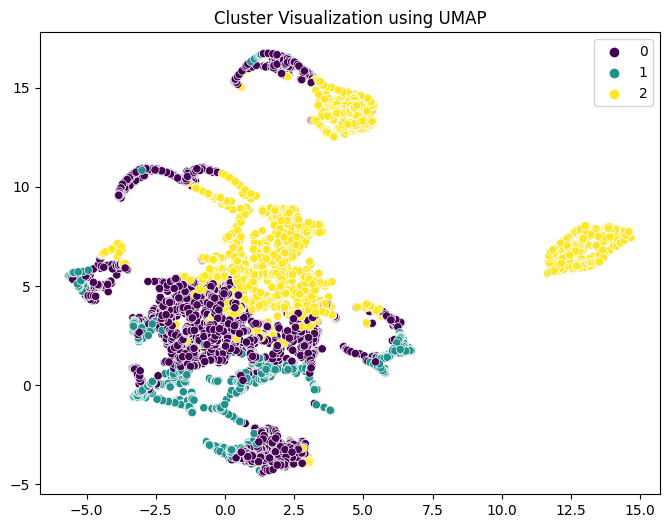

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=cluster_labels, palette="viridis")
plt.title(f"Cluster Visualization using UMAP")
plt.show()

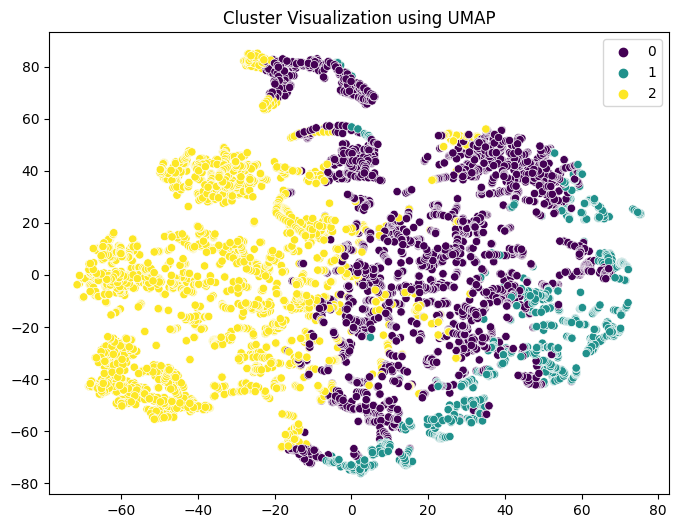

In [19]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=cluster_labels, palette="viridis")
plt.title(f"Cluster Visualization using UMAP")
plt.show()